Based on:

@book{leborgne2022fraud,

title={Reproducible Machine Learning for Credit Card Fraud Detection - Practical Handbook},

author={Le Borgne, Yann-A{\"e}l and Siblini, Wissam and Lebichot, Bertrand and Bontempi, Gianluca},

url={https://github.com/Fraud-Detection-Handbook/fraud-detection-handbook},

year={2022},

publisher={Universit{\'e} Libre de Bruxelles}

}

Covered subchapters:
* 5.3 Model selection

In [29]:
import datetime
import sklearn
import time
import pickle
import xgboost

import wandb

In [15]:
%run ../shared_functions.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 63257  100 63257    0     0   177k      0 --:--:-- --:--:-- --:--:--  177k


In [26]:
%run ../my_shared_functions.py

In [17]:
DIR_INPUT = '../../fraud-detection-handbook/simulated-data-transformed/data/'

BEGIN_DATE = "2018-06-11"
END_DATE = "2018-09-14"

print("Load  files")
transactions_df = read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE)
print("{0} transactions loaded, containing {1} fraudulent transactions".format(len(transactions_df),transactions_df.TX_FRAUD.sum()))

output_feature = "TX_FRAUD"

input_features = ['TX_AMOUNT','TX_DURING_WEEKEND', 'TX_DURING_NIGHT', 'CUSTOMER_ID_NB_TX_1DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW', 'CUSTOMER_ID_NB_TX_7DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW', 'CUSTOMER_ID_NB_TX_30DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW', 'TERMINAL_ID_NB_TX_1DAY_WINDOW',
       'TERMINAL_ID_RISK_1DAY_WINDOW', 'TERMINAL_ID_NB_TX_7DAY_WINDOW',
       'TERMINAL_ID_RISK_7DAY_WINDOW', 'TERMINAL_ID_NB_TX_30DAY_WINDOW',
       'TERMINAL_ID_RISK_30DAY_WINDOW']

Load  files
919767 transactions loaded, containing 8195 fraudulent transactions


In [18]:
n_folds = 4

start_date_training = datetime.datetime.strptime("2018-07-25", "%Y-%m-%d")
delta_train = delta_delay = delta_test = delta_valid = delta_assessment = 7

start_date_training_for_valid = start_date_training+datetime.timedelta(days=-(delta_delay+delta_valid))
start_date_training_for_test = start_date_training+datetime.timedelta(days=(n_folds-1)*delta_test)

In [24]:
start_date_training_for_test

datetime.datetime(2018, 8, 15, 0, 0)

In [22]:
start_date_training

datetime.datetime(2018, 7, 25, 0, 0)

In [23]:
start_date_training_for_valid

datetime.datetime(2018, 7, 11, 0, 0)

In [19]:
# Only keep columns that are needed as argument to the custom scoring function
# (in order to reduce the serialization time of transaction dataset)
transactions_df_scorer = transactions_df[['CUSTOMER_ID', 'TX_FRAUD','TX_TIME_DAYS']]

card_precision_top_100 = sklearn.metrics.make_scorer(card_precision_top_k_custom, 
                                                     needs_proba=True, 
                                                     top_k=100, 
                                                     transactions_df=transactions_df_scorer)

performance_metrics_list_grid = ['roc_auc', 'average_precision', 'f1_score', 'card_precision@100']
performance_metrics_list = ['AUC ROC', 'Average precision', 'F1 score', 'Card Precision@100']

scoring = {'roc_auc':'roc_auc',
           'average_precision': 'average_precision',
           'f1_score': 'f1',
           'card_precision@100': card_precision_top_100,
           }

##### Decision tree

In [20]:
classifier = sklearn.tree.DecisionTreeClassifier()

parameters = {'clf__max_depth':[2,3,4,5,6,7,8,9,10,20,50], 'clf__random_state':[0]}

start_time = time.time()

# model_selection_wrapper - performs prequential validation for both the validation and the test sets
performances_df=model_selection_wrapper(transactions_df, classifier, 
                                        input_features, output_feature,
                                        parameters, scoring, 
                                        start_date_training_for_valid,
                                        start_date_training_for_test,
                                        n_folds=n_folds,
                                        delta_train=delta_train, 
                                        delta_delay=delta_delay, 
                                        delta_assessment=delta_assessment,
                                        performance_metrics_list_grid=performance_metrics_list_grid,
                                        performance_metrics_list=performance_metrics_list,
                                        n_jobs=1)

execution_time_dt = time.time()-start_time

parameters_dict=dict(performances_df['Parameters'])
performances_df['Parameters summary']=[parameters_dict[i]['clf__max_depth'] for i in range(len(parameters_dict))]

performances_df_dt=performances_df

In [21]:
performances_df_dt

,AUC ROC Test,AUC ROC Test Std,Average precision Test,Average precision Test Std,F1 score Test,F1 score Test Std,Card Precision@100 Test,Card Precision@100 Test Std,Parameters,Execution time,AUC ROC Validation,AUC ROC Validation Std,Average precision Validation,Average precision Validation Std,F1 score Validation,F1 score Validation Std,Card Precision@100 Validation,Card Precision@100 Validation Std,Parameters summary
0,0.791909,0.017769,0.541761,0.031476,0.682641,0.028960,0.265000,0.019756,"{'clf__max_depth': 2, 'clf__random_state': 0}",0.337760,0.790786,0.012035,0.549767,0.022134,0.696661,0.015600,0.256429,0.014481,2
1,0.809012,0.009125,0.578885,0.014434,0.682248,0.029176,0.281429,0.015940,"{'clf__max_depth': 3, 'clf__random_state': 0}",0.378011,0.802717,0.017607,0.573414,0.027186,0.699548,0.014833,0.267143,0.016067,3
2,0.812555,0.010319,0.601088,0.020216,0.694723,0.024146,0.282500,0.015199,"{'clf__max_depth': 4, 'clf__random_state': 0}",0.427092,0.800690,0.017878,0.554134,0.038293,0.699513,0.019360,0.264286,0.014321,4
3,0.810138,0.008586,0.600306,0.016797,0.699152,0.021309,0.284286,0.004286,"{'clf__max_depth': 5, 'clf__random_state': 0}",0.487749,0.804218,0.016505,0.546094,0.042197,0.693462,0.022429,0.267857,0.013869,5
4,0.804437,0.007974,0.585132,0.005053,0.701491,0.020001,0.281429,0.007626,"{'clf__max_depth': 6, 'clf__random_state': 0}",0.525000,0.798603,0.024225,0.537006,0.037056,0.691973,0.022805,0.264643,0.008474,6
5,0.782710,0.012483,0.554860,0.011771,0.691313,0.017626,0.268929,0.009813,"{'clf__max_depth': 7, 'clf__random_state': 0}",0.572001,0.795636,0.023144,0.530609,0.040323,0.686371,0.023282,0.262500,0.006804,7
6,0.774783,0.014568,0.544933,0.003392,0.696453,0.006033,0.263571,0.007593,"{'clf__max_depth': 8, 'clf__random_state': 0}",0.613778,0.795142,0.023081,0.516246,0.033545,0.686132,0.021293,0.260714,0.009715,8
7,0.761763,0.012098,0.520208,0.012309,0.687859,0.012424,0.258571,0.009949,"{'clf__max_depth': 9, 'clf__random_state': 0}",0.657595,0.785849,0.026249,0.505189,0.040393,0.685685,0.028389,0.260357,0.009813,9
8,0.758138,0.011140,0.504909,0.013154,0.689483,0.014215,0.257500,0.010467,"{'clf__max_depth': 10, 'clf__random_state': 0}",0.703473,0.786784,0.031165,0.493543,0.048307,0.681165,0.035125,0.257143,0.009949,10
9,0.754024,0.009848,0.439422,0.034828,0.653977,0.024159,0.261071,0.014335,"{'clf__max_depth': 20, 'clf__random_state': 0}",1.147771,0.780408,0.022168,0.450980,0.031413,0.664912,0.025171,0.264286,0.007890,20


In [27]:
summary_performances_dt=get_summary_performances_f1_included(performances_df_dt, parameter_column_name="Parameters summary")
summary_performances_dt

,AUC ROC,Average precision,F1 score,Card Precision@100
Best estimated parameters,50,3,3,5
Validation performance,0.823+/-0.01,0.573+/-0.03,0.7+/-0.01,0.268+/-0.01
Test performance,0.797+/-0.01,0.579+/-0.01,0.682+/-0.03,0.284+/-0.0
Optimal parameter(s),4,4,6,5
Optimal test performance,0.813+/-0.01,0.601+/-0.02,0.701+/-0.02,0.284+/-0.0


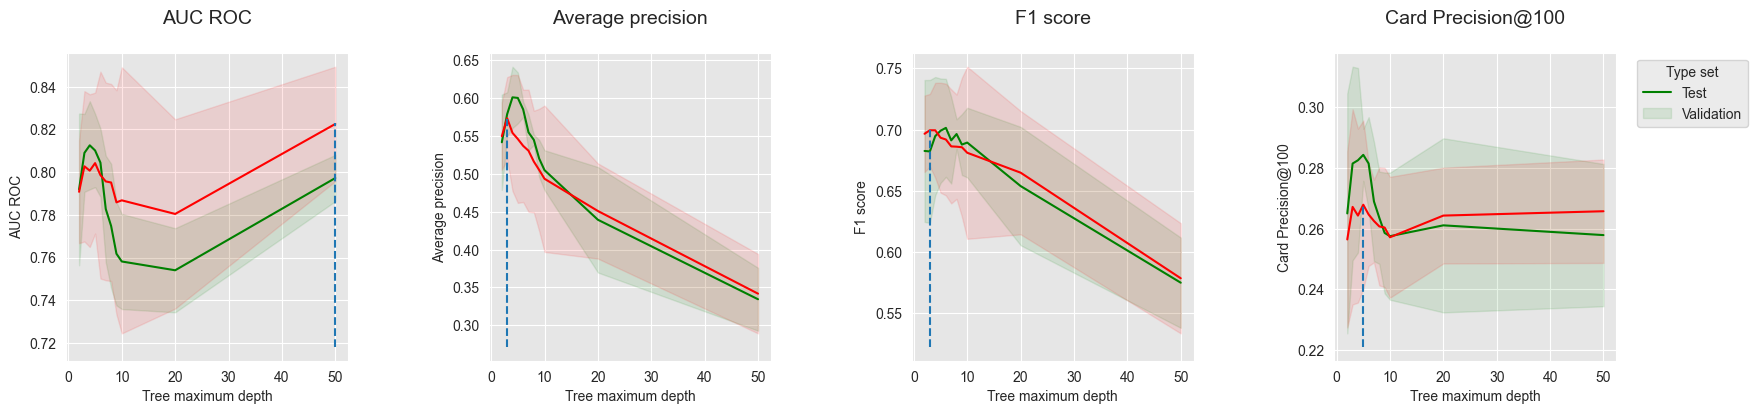

In [28]:
get_performances_plots(performances_df_dt, 
                       performance_metrics_list=['AUC ROC', 'Average precision', 'F1 score', 'Card Precision@100'], 
                       expe_type_list=['Test','Validation'], expe_type_color_list=['#008000','#FF0000'],
                       summary_performances=summary_performances_dt)

In [33]:
(train_df, test_df) = get_train_test_set(transactions_df,start_date_training+datetime.timedelta(days=delta_train+delta_delay),
                                       delta_train=7,delta_delay=7,delta_test=7)
                                       
classifier = sklearn.tree.DecisionTreeClassifier(max_depth=5, random_state=0)
model_and_predictions_dictionary = fit_model_and_get_predictions(classifier, train_df, test_df, 
                                                                 input_features, output_feature,
                                                                 scale=True)
predictions_df=test_df
predictions_df['predictions']=model_and_predictions_dictionary['predictions_test']
performance_df = performance_assessment_f1_included(predictions_df, top_k_list=[100])

pickle.dump(classifier, open('../models/ML_imbalance_not_considered/dt_maxdepth5/dt_maxdepth5_model.sav', 'wb'))

In [34]:
config_dt = dict(
    dataset_id = 'fraud-detection-handbook-transformed',
    validation = 'prequential validation',
    begin_date = '2018-08-08',
    delta_train = 7,
    delta_delay = 7,
    delta_test = 7,
    delta_assessment = 7,
    n_folds = 4,
    random_state = 0,
    max_depth = 5,
    scale = True
)
wandb.init(project="mgr-anomaly-tsxai-project", config=config_dt, tags=['hypertuned', 'decision-tree', 'imbalance-not-considered'])
wandb.log({'Training execution time': model_and_predictions_dictionary['training_execution_time']})
wandb.log({'Prediction execution time':  model_and_predictions_dictionary['prediction_execution_time']})
wandb.log({'AUC ROC': performance_df.loc[0,'AUC ROC']})
wandb.log({'Average precision': performance_df.loc[0,'Average precision']})
wandb.log({'F1 score': performance_df.loc[0,'F1 score']})
wandb.log({'Card Precision@100': performance_df.loc[0,'Card Precision@100']})

dt_artifact = wandb.Artifact('dt_maxdepth5', type='decision_tree', description='trained hypertuned decision tree with max_depth=5')
dt_artifact.add_dir('../models/ML_imbalance_not_considered/dt_maxdepth5')
wandb.log_artifact(dt_artifact)
wandb.finish()

wandb: Adding directory to artifact (.\models\ML_imbalance_not_considered\dt_maxdepth5)... Done. 0.0s


AUC ROC,▁
Average precision,▁
Card Precision@100,▁
F1 score,▁
Prediction execution time,▁
Training execution time,▁
AUC ROC,0.814
Average precision,0.581
Card Precision@100,0.28
F1 score,0.668
Prediction execution time,0.013


##### Logistic regression

In [35]:
classifier = sklearn.linear_model.LogisticRegression()

parameters = {'clf__C':[0.1,1,10,100], 'clf__random_state':[0]}

start_time=time.time()

performances_df=model_selection_wrapper(transactions_df, classifier, 
                                        input_features, output_feature,
                                        parameters, scoring, 
                                        start_date_training_for_valid,
                                        start_date_training_for_test,
                                        n_folds=n_folds,
                                        delta_train=delta_train, 
                                        delta_delay=delta_delay, 
                                        delta_assessment=delta_assessment,
                                        performance_metrics_list_grid=performance_metrics_list_grid,
                                        performance_metrics_list=performance_metrics_list,
                                        n_jobs=1)

execution_time_lr = time.time()-start_time

parameters_dict=dict(performances_df['Parameters'])
performances_df['Parameters summary']=[parameters_dict[i]['clf__C'] for i in range(len(parameters_dict))]

performances_df_lr=performances_df

In [36]:
summary_performances_lr=get_summary_performances_f1_included(performances_df_lr, parameter_column_name="Parameters summary")
summary_performances_lr

,AUC ROC,Average precision,F1 score,Card Precision@100
Best estimated parameters,100.0,100.0,1.0,0.1
Validation performance,0.867+/-0.01,0.613+/-0.02,0.623+/-0.01,0.279+/-0.02
Test performance,0.868+/-0.02,0.623+/-0.02,0.637+/-0.03,0.297+/-0.01
Optimal parameter(s),100.0,100.0,100.0,10.0
Optimal test performance,0.868+/-0.02,0.623+/-0.02,0.639+/-0.04,0.298+/-0.01


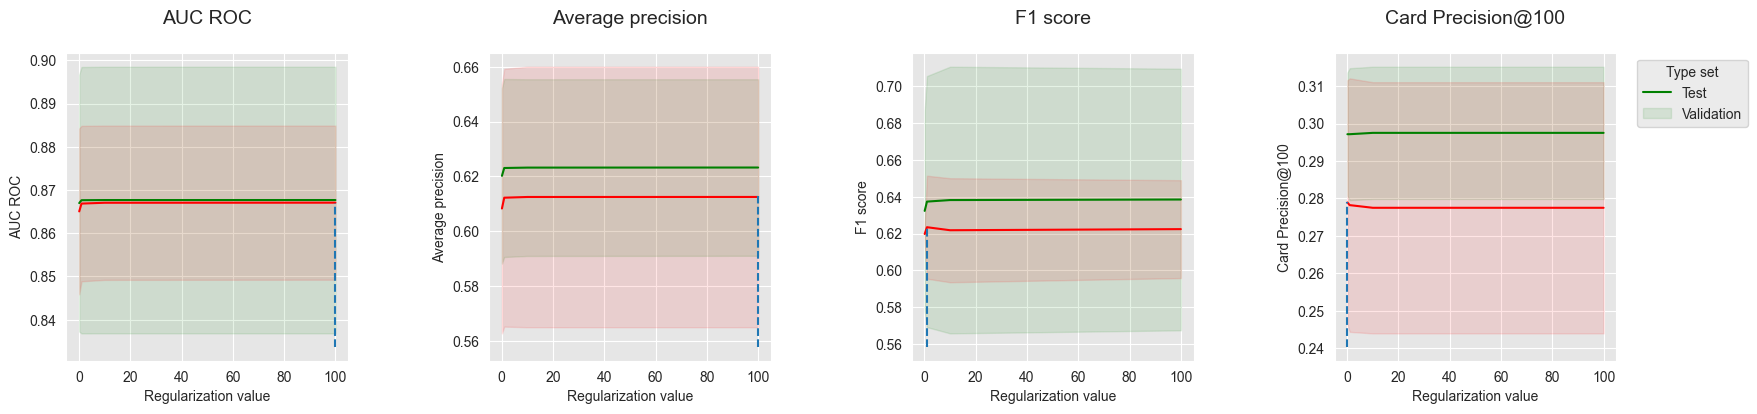

In [37]:
get_performances_plots(performances_df_lr, 
                       performance_metrics_list=['AUC ROC', 'Average precision', 'F1 score', 'Card Precision@100'], 
                       expe_type_list=['Test','Validation'], expe_type_color_list=['#008000','#FF0000'],
                       parameter_name="Regularization value",
                       summary_performances=summary_performances_lr)

In [40]:
(train_df, test_df) = get_train_test_set(transactions_df,start_date_training+datetime.timedelta(days=delta_train+delta_delay),
                                       delta_train=7,delta_delay=7,delta_test=7)

classifier = sklearn.linear_model.LogisticRegression(C=100, random_state=0)
model_and_predictions_dictionary = fit_model_and_get_predictions(classifier, train_df, test_df, 
                                                                 input_features, output_feature,
                                                                 scale=True)
predictions_df=test_df
predictions_df['predictions']=model_and_predictions_dictionary['predictions_test']
performance_df = performance_assessment_f1_included(predictions_df, top_k_list=[100])

pickle.dump(classifier, open('../models/ML_imbalance_not_considered/lr_hypertuned/lr_C100_model.sav', 'wb'))

In [41]:
config_lr = dict(
    dataset_id = 'fraud-detection-handbook-transformed',
    validation = 'prequential validation',
    begin_date = '2018-08-08',
    delta_train = 7,
    delta_delay = 7,
    delta_test = 7,
    delta_assessment = 7,
    n_folds = 4,
    random_state = 0,
    scale=True,
    C = 100
)
wandb.init(project="mgr-anomaly-tsxai-project", config=config_lr, tags=['hypertuned', 'logistic-regression', 'imbalance-not-considered'])
wandb.log({'Training execution time': model_and_predictions_dictionary['training_execution_time']})
wandb.log({'Prediction execution time':  model_and_predictions_dictionary['prediction_execution_time']})
wandb.log({'AUC ROC': performance_df.loc[0,'AUC ROC']})
wandb.log({'Average precision': performance_df.loc[0,'Average precision']})
wandb.log({'F1 score': performance_df.loc[0,'F1 score']})
wandb.log({'Card Precision@100': performance_df.loc[0,'Card Precision@100']})

lr_artifact = wandb.Artifact('lr_hypertuned', type='logistic_regression', description='trained hypertuned logistic regression with C=100')
lr_artifact.add_dir('../models/ML_imbalance_not_considered/lr_hypertuned')
wandb.log_artifact(lr_artifact)
wandb.finish()

wandb: Adding directory to artifact (.\models\ML_imbalance_not_considered\lr_hypertuned)... Done. 0.0s


AUC ROC,▁
Average precision,▁
Card Precision@100,▁
F1 score,▁
Prediction execution time,▁
Training execution time,▁
AUC ROC,0.871
Average precision,0.606
Card Precision@100,0.291
F1 score,0.616
Prediction execution time,0.013


##### Random Forest

In [ ]:
classifier = sklearn.ensemble.RandomForestClassifier()

# Note: n_jobs set to one for getting true execution times
parameters = {'clf__max_depth':[5,10,20,50], 'clf__n_estimators':[25,50,100],
              'clf__random_state':[0],'clf__n_jobs':[1]}

start_time=time.time()

performances_df=model_selection_wrapper(transactions_df, classifier, 
                                        input_features, output_feature,
                                        parameters, scoring, 
                                        start_date_training_for_valid,
                                        start_date_training_for_test,
                                        n_folds=n_folds,
                                        delta_train=delta_train, 
                                        delta_delay=delta_delay, 
                                        delta_assessment=delta_assessment,
                                        performance_metrics_list_grid=performance_metrics_list_grid,
                                        performance_metrics_list=performance_metrics_list,
                                        n_jobs=1)

execution_time_rf = time.time()-start_time

parameters_dict=dict(performances_df['Parameters'])
performances_df['Parameters summary']=[str(parameters_dict[i]['clf__n_estimators'])+
                                   '/'+
                                   str(parameters_dict[i]['clf__max_depth'])
                                   for i in range(len(parameters_dict))]

performances_df_rf=performances_df

In [ ]:
summary_performances_rf=get_summary_performances_f1_included(performances_df_rf, parameter_column_name="Parameters summary")
summary_performances_rf

,AUC ROC,Average precision,Card Precision@100
Best estimated parameters,100/20,100/20,100/20
Validation performance,0.88+/-0.01,0.694+/-0.02,0.289+/-0.02
Test performance,0.87+/-0.02,0.678+/-0.01,0.299+/-0.01
Optimal parameter(s),100/10,100/20,100/10
Optimal test performance,0.875+/-0.01,0.678+/-0.01,0.303+/-0.01


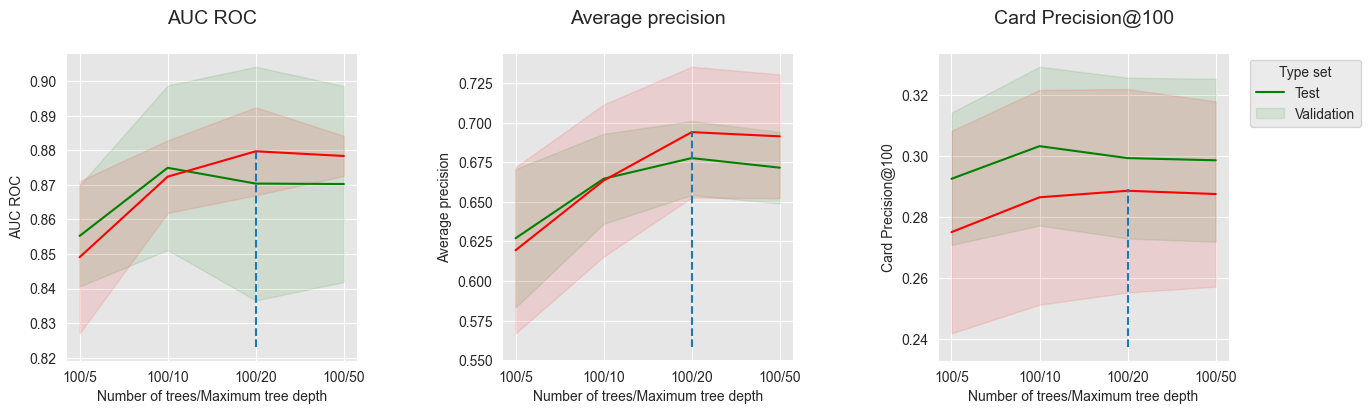

In [ ]:
performances_df_rf_fixed_number_of_trees=performances_df_rf[performances_df_rf["Parameters summary"].str.startswith("100")]

summary_performances_fixed_number_of_trees=get_summary_performances_f1_included(performances_df_rf_fixed_number_of_trees, parameter_column_name="Parameters summary")

get_performances_plots(performances_df_rf_fixed_number_of_trees, 
                       performance_metrics_list=['AUC ROC', 'Average precision', 'F1 score', 'Card Precision@100'], 
                       expe_type_list=['Test','Validation'], expe_type_color_list=['#008000','#FF0000'],
                       parameter_name="Number of trees/Maximum tree depth",
                       summary_performances=summary_performances_fixed_number_of_trees)

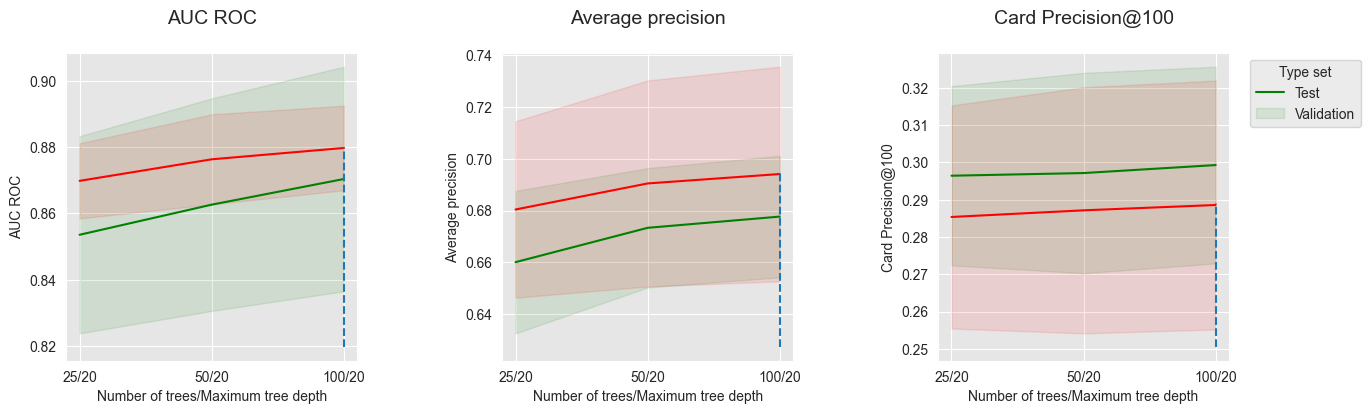

In [ ]:
performances_df_rf_fixed_max_tree_depth=performances_df_rf[performances_df_rf["Parameters summary"].str.endswith("20")]

summary_performances_fixed_max_tree_depth=get_summary_performances_f1_included(performances_df_rf_fixed_max_tree_depth, parameter_column_name="Parameters summary")

get_performances_plots(performances_df_rf_fixed_max_tree_depth, 
                       performance_metrics_list=['AUC ROC', 'Average precision', 'F1 score', 'Card Precision@100'], 
                       expe_type_list=['Test','Validation'], expe_type_color_list=['#008000','#FF0000'],
                       parameter_name="Number of trees/Maximum tree depth",
                       summary_performances=summary_performances_fixed_max_tree_depth)

In [43]:
(train_df, test_df) = get_train_test_set(transactions_df,start_date_training+datetime.timedelta(days=delta_train+delta_delay),
                                       delta_train=7,delta_delay=7,delta_test=7)

classifier = sklearn.ensemble.RandomForestClassifier(max_depth=20, n_estimators=100, random_state=0, n_jobs=-1)
model_and_predictions_dictionary = fit_model_and_get_predictions(classifier, train_df, test_df, 
                                                                 input_features, output_feature,
                                                                 scale=True)
predictions_df=test_df
predictions_df['predictions']=model_and_predictions_dictionary['predictions_test']
performance_df = performance_assessment_f1_included(predictions_df, top_k_list=[100])
pickle.dump(classifier, open('../models/ML_imbalance_not_considered/rf_hypertuned/rf_maxdepth20_nestimators100_model.sav', 'wb'))

In [44]:
config_rf = dict(
    dataset_id = 'fraud-detection-handbook-transformed',
    validation = 'prequential validation',
    begin_date = '2018-08-08',
    delta_train = 7,
    delta_delay = 7,
    delta_test = 7,
    delta_assessment = 7,
    n_folds = 4,
    random_state = 0,
    n_jobs=-1,
    scale=True,
    max_depth=20,
    n_estimators=100
)
wandb.init(project="mgr-anomaly-tsxai-project", config=config_rf, tags=['hypertuned', 'random-forest', 'imbalance-not-considered'])
wandb.log({'Training execution time': model_and_predictions_dictionary['training_execution_time']})
wandb.log({'Prediction execution time':  model_and_predictions_dictionary['prediction_execution_time']})
wandb.log({'AUC ROC': performance_df.loc[0,'AUC ROC']})
wandb.log({'Average precision': performance_df.loc[0,'Average precision']})
wandb.log({'F1 score': performance_df.loc[0,'F1 score']})
wandb.log({'Card Precision@100': performance_df.loc[0,'Card Precision@100']})

rf_artifact = wandb.Artifact('rf_hypertuned', type='random_forest', description='trained hypertuned random forest with max_depth=20 and n_estimators=100')
rf_artifact.add_dir('../models/ML_imbalance_not_considered/rf_hypertuned')
wandb.log_artifact(rf_artifact)
wandb.finish()

wandb: Adding directory to artifact (.\models\ML_imbalance_not_considered\rf_hypertuned)... Done. 0.0s


AUC ROC,▁
Average precision,▁
Card Precision@100,▁
F1 score,▁
Prediction execution time,▁
Training execution time,▁
AUC ROC,0.863
Average precision,0.661
Card Precision@100,0.287
F1 score,0.659
Prediction execution time,0.111


##### XGBoost

In [24]:
classifier = xgboost.XGBClassifier()

parameters = {'clf__max_depth':[3,6,9], 'clf__n_estimators':[25,50,100], 'clf__learning_rate':[0.1, 0.3],
              'clf__random_state':[0], 'clf__n_jobs':[1], 'clf__verbosity':[0]}

start_time=time.time()

performances_df=model_selection_wrapper(transactions_df, classifier, 
                                        input_features, output_feature,
                                        parameters, scoring, 
                                        start_date_training_for_valid,
                                        start_date_training_for_test,
                                        n_folds=n_folds,
                                        delta_train=delta_train, 
                                        delta_delay=delta_delay, 
                                        delta_assessment=delta_assessment,
                                        performance_metrics_list_grid=performance_metrics_list_grid,
                                        performance_metrics_list=performance_metrics_list,
                                        n_jobs=1)

execution_time_boosting = time.time()-start_time

parameters_dict=dict(performances_df['Parameters'])
performances_df['Parameters summary']=[str(parameters_dict[i]['clf__n_estimators'])+
                                   '/'+
                                   str(parameters_dict[i]['clf__learning_rate'])+
                                   '/'+
                                   str(parameters_dict[i]['clf__max_depth'])
                                   for i in range(len(parameters_dict))]

performances_df_xgboost=performances_df

In [25]:
summary_performances_xgboost=get_summary_performances_f1_included(performances_df_xgboost, parameter_column_name="Parameters summary")
summary_performances_xgboost

,AUC ROC,Average precision,Card Precision@100
Best estimated parameters,100/0.3/3,50/0.3/3,25/0.3/3
Validation performance,0.887+/-0.01,0.708+/-0.02,0.289+/-0.02
Test performance,0.869+/-0.01,0.687+/-0.01,0.303+/-0.01
Optimal parameter(s),50/0.3/3,100/0.1/3,100/0.1/3
Optimal test performance,0.872+/-0.01,0.694+/-0.01,0.304+/-0.01


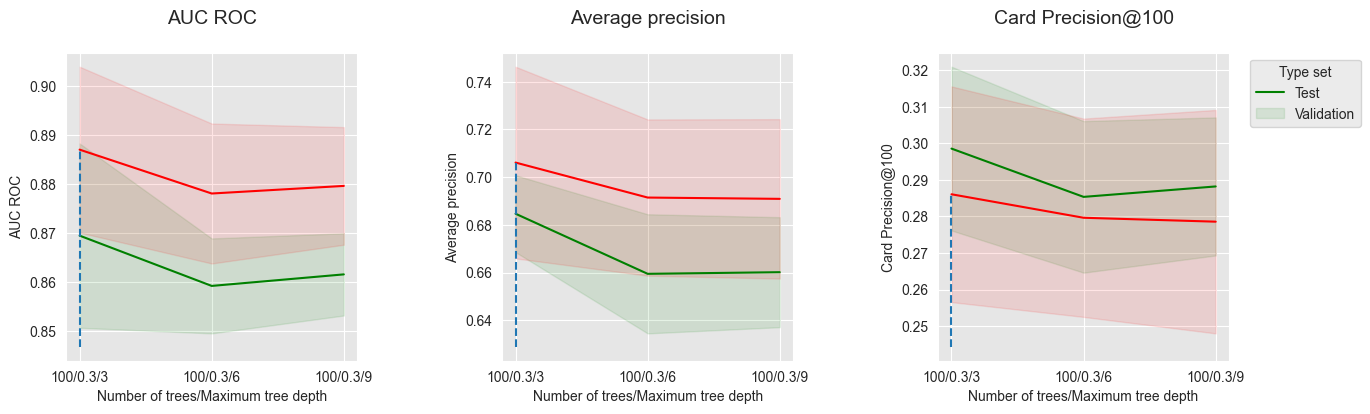

In [26]:
performances_df_xgboost_fixed_number_of_trees=performances_df_xgboost[performances_df_xgboost["Parameters summary"].str.startswith("100/0.3")]

summary_performances_fixed_number_of_trees=get_summary_performances_f1_included(performances_df_xgboost_fixed_number_of_trees, parameter_column_name="Parameters summary")

get_performances_plots(performances_df_xgboost_fixed_number_of_trees, 
                       performance_metrics_list=['AUC ROC', 'Average precision', 'F1 score', 'Card Precision@100'], 
                       expe_type_list=['Test','Validation'], expe_type_color_list=['#008000','#FF0000'],
                       parameter_name="Number of trees/Maximum tree depth",
                       summary_performances=summary_performances_fixed_number_of_trees)

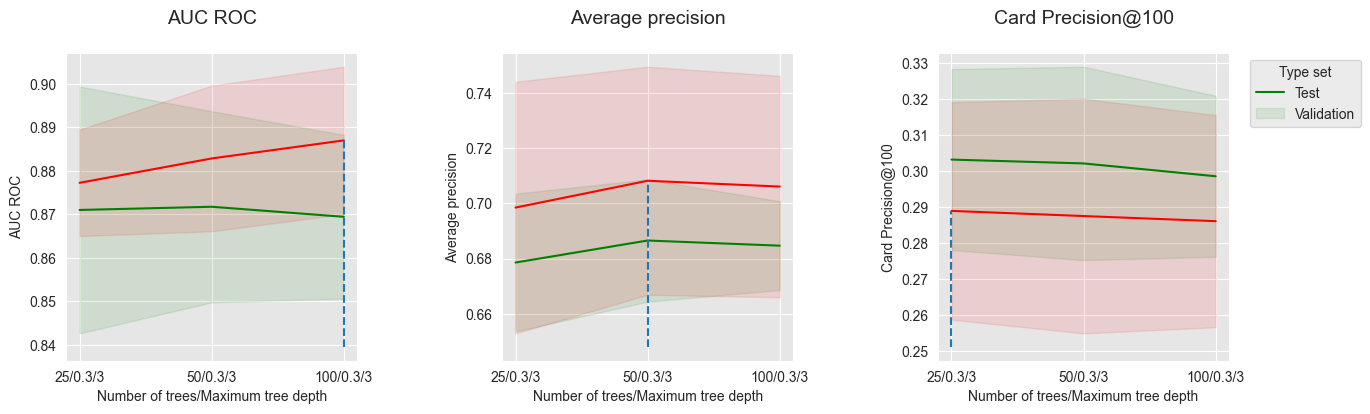

In [27]:
performances_df_xgboost_fixed_max_tree_depth=performances_df_xgboost[performances_df_xgboost["Parameters summary"].str.endswith("0.3/3")]

summary_performances_fixed_max_tree_depth=get_summary_performances_f1_included(performances_df_xgboost_fixed_max_tree_depth, parameter_column_name="Parameters summary")

get_performances_plots(performances_df_xgboost_fixed_max_tree_depth, 
                       performance_metrics_list=['AUC ROC', 'Average precision', 'F1 score', 'Card Precision@100'], 
                       expe_type_list=['Test','Validation'], expe_type_color_list=['#008000','#FF0000'],
                       parameter_name="Number of trees/Maximum tree depth",
                       summary_performances=summary_performances_fixed_max_tree_depth)

In [45]:
(train_df, test_df) = get_train_test_set(transactions_df,start_date_training+datetime.timedelta(days=delta_train+delta_delay),
                                       delta_train=7,delta_delay=7,delta_test=7)

classifier = xgboost.XGBClassifier(max_depth=3, n_estimators=50, learning_rate=0.3, random_state=0, n_jobs=-1, verbosity=0)
model_and_predictions_dictionary = fit_model_and_get_predictions(classifier, train_df, test_df, 
                                                                 input_features, output_feature,
                                                                 scale=True)
predictions_df=test_df
predictions_df['predictions']=model_and_predictions_dictionary['predictions_test']
performance_df = performance_assessment_f1_included(predictions_df, top_k_list=[100])
pickle.dump(classifier, open('../models/ML_imbalance_not_considered/xgb_hypertuned/xgb_maxdepth3_nestimators50_lr0dot3_model.sav', 'wb'))

In [46]:
config_xgb = dict(
    dataset_id = 'fraud-detection-handbook-transformed',
    validation = 'prequential validation',
    begin_date = '2018-08-08',
    delta_train = 7,
    delta_delay = 7,
    delta_test = 7,
    delta_assessment = 7,
    n_folds = 4,
    random_state = 0,
    n_jobs=-1,
    scale=True,
    max_depth=3,
    n_estimators=50,
    learning_rate=0.3
)
wandb.init(project="mgr-anomaly-tsxai-project", config=config_xgb, tags=['hypertuned', 'xgboost', 'imbalance-not-considered'])
wandb.log({'Training execution time': model_and_predictions_dictionary['training_execution_time']})
wandb.log({'Prediction execution time':  model_and_predictions_dictionary['prediction_execution_time']})
wandb.log({'AUC ROC': performance_df.loc[0,'AUC ROC']})
wandb.log({'Average precision': performance_df.loc[0,'Average precision']})
wandb.log({'F1 score': performance_df.loc[0,'F1 score']})
wandb.log({'Card Precision@100': performance_df.loc[0,'Card Precision@100']})

xgb_artifact = wandb.Artifact('xgb_hypertuned', type='xgboost', description='trained hypertuned xgboost')
xgb_artifact.add_dir('../models/ML_imbalance_not_considered/xgb_hypertuned')
wandb.log_artifact(xgb_artifact)
wandb.finish()

wandb: Adding directory to artifact (.\models\ML_imbalance_not_considered\xgb_hypertuned)... Done. 0.0s


AUC ROC,▁
Average precision,▁
Card Precision@100,▁
F1 score,▁
Prediction execution time,▁
Training execution time,▁
AUC ROC,0.88
Average precision,0.67
Card Precision@100,0.293
F1 score,0.69
Prediction execution time,0.025


In [29]:
execution_times=[execution_time_dt,execution_time_lr,
                 execution_time_rf,execution_time_boosting]

In [30]:
%%capture

fig_model_selection_execution_times_for_each_model_class, ax = plt.subplots(1, 1, figsize=(5,4))

model_classes=['Decision Tree','Logistic Regression','Random Forest','XGBoost']
    
barWidth = 0.3
r1 = np.arange(len(model_classes))
    
ax.bar(r1, execution_times[0:4], 
        width = barWidth, color = 'black', edgecolor = 'black', 
        capsize=7)

ax.set_xticks(r1+barWidth/2)
ax.set_xticklabels(model_classes, rotation = 45, ha="right", fontsize=12)
ax.set_title('Model selection execution times \n for different model classes', fontsize=18)
ax.set_xlabel("Model class", fontsize=16)
ax.set_ylabel("Execution times (s)", fontsize=15)

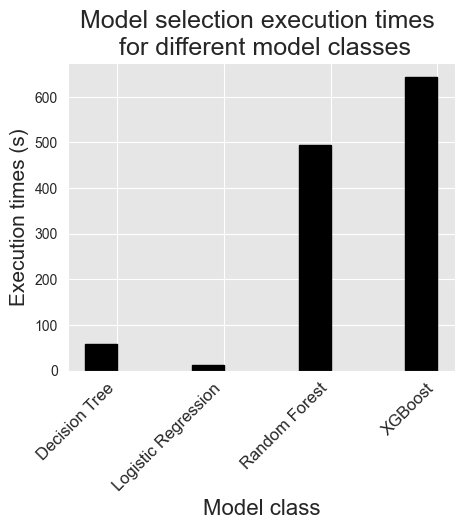

In [31]:
fig_model_selection_execution_times_for_each_model_class